# Tutorial 4. Network Simulation

In this tutorial I show how we can combine several simulation iterations in order to find out what would have been the most likely paths.

### imports

In [1]:
import netsim.generate as ng
import netsim.utils as utils
import netsim.path_tools as ptools
import netsim.simulate as ns
import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio as ro

### Reading files

#### *Read DEM*

In [2]:
fn = r'..\data\sample\sampleDEM.tif'

In [3]:
dem, profile = utils.read_raster(fn)

In [4]:
#find the cellsize of the dem
cellsize = profile['transform'].a

#### *Read shapefile into a geopandas dataframe*

In [5]:
# change 5 or 15
fn = r'..\data\sample\sample5.shp'

##### read and make a copy of original dataframe

In [6]:
df_temp = gpd.read_file(fn)

# make a copy
df = df_temp.copy(deep=True)
df

,id,seq,group,mix,easting,northing,geometry
0,0,1,1,0,530782,4389390,POINT (530782 4389390)
1,1,1,1,0,531119,4388860,POINT (531119 4388860)
2,2,1,1,0,530403,4388580,POINT (530403 4388580)
3,3,1,1,0,530503,4388620,POINT (530503 4388620)
4,4,1,1,0,530729,4388930,POINT (530729 4388930)
5,5,1,1,0,530606,4389150,POINT (530606 4389150)


### Preliminaries

#### *Convert point coordinates into rows and column and add to dataframe*

In [7]:
df['r'], df['c'] = utils.pt2rc(df['geometry'], profile)
df

,id,seq,group,mix,easting,northing,geometry,r,c
0,0,1,1,0,530782,4389390,POINT (530782 4389390),18,104
1,1,1,1,0,531119,4388860,POINT (531119 4388860),124,171
2,2,1,1,0,530403,4388580,POINT (530403 4388580),180,28
3,3,1,1,0,530503,4388620,POINT (530503 4388620),172,48
4,4,1,1,0,530729,4388930,POINT (530729 4388930),110,93
5,5,1,1,0,530606,4389150,POINT (530606 4389150),66,68


In [9]:
# check values
df = ng.check(df)


 No corrections or errors !! 


#### *Plot locations*

In [10]:
hillshade = utils.calculate_hillshade(dem)

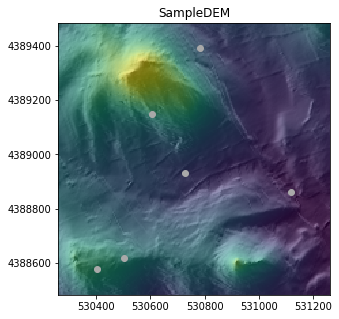

In [11]:
utils.plot_map({'ras':dem, 'profile':profile, 'bground': hillshade}, loc=df, title='SampleDEM')

### create network generator

In [12]:
# create network generator
netgentor, net_info, total_iterations = ng.create_network_generator(df)


 iteration broken per group....

   group  num_loc  num_iter iter_type
0      1        6       100    sample

 total number of iterations.... 100


### Setup Simulation

##### *find coefficients for gradient to cost function*

In [14]:
# vertical factor table
vftfn = r'..\data\iwdt\grad2cost.csv'

# read file slope (tan) to cost
vft = np.genfromtxt(vftfn, delimiter=',')

In [15]:
# fit values to 4th degree polynomial and return coefficients
coef = np.polyfit(np.tan(np.radians(vft[: , 0])), vft[:,1], deg=4)
coef

array([ 14.58472386, -20.89105302,  41.30992529,  16.89952776,
         2.57058679])

##### Set up cost dictionary

In [16]:
cost_dict={
    'dem': dem,
    'netcost': np.zeros_like(dem),
    'cellsize': cellsize,
    'weight': 0.5,
    'coef': coef
}

##### Set up netsim dictionary

##### *calculate decay factor $\alpha$ for given $d_0$ and $NC_0$*

We shall specify that at a distance of $d_0$=10m the network cost (i.e. the effect of the existing network) will decrease to $\frac{1}{2} $.  

In [17]:
from math import log

d0 = 10 # distance @ which 
NC0 = 0.5  # cost reduces to 50%
alpha = d0 / log(1- NC0)

In [18]:
netsim_dict= {
    'i': 1.0,      # path impact
    'Gmax': 5.0,   # path saturation
    'T': 10,       # residuality 
    'alpha': alpha # decay factor 
    }

#### Run *nsim* simulations

In [19]:
progress = lambda i, n=10: print (i//n, end = "") if i % n == 0 else print('.', end = "")

In [20]:
# number of iterations 
nsim = 2

##### initialize variables

In [21]:
all_path_lst = []
all_paths = np.zeros_like(dem, dtype=np.float64)
prev_id = 0
save_flag = False
save_fn =  './all_paths'

##### run simulations

In [22]:
for isim in range(nsim):
    
    # progress
    progress(isim)
    
    # generate network iteration
    net_iteration = list(next(netgentor))
    
    # create path network layout for current iteration
    df_net = ng.network_layout(df, net_iteration, isim, opt='decentral')
    
    # simulate network
    _, paths, path_lst = ns.simulation(df, df_net, cost_dict, netsim_dict)
    
    # add current iteration path list to that of previous iterations 
    for pth in path_lst:
        pth['id'] += len(all_path_lst)
    all_path_lst += path_lst
    
    # generate dataframe output
    df_paths = pd.DataFrame(all_path_lst, columns=['id', 'origin','destination', 'track'])
    
    # add current path network to path networks from previous iterations
    all_paths += paths
    
    if save_flag:
        df_paths.to_pickle(save_fn)
        with ro.open( save_fn+'.tif', 'w', **profile) as ras:
            ras.write(all_paths, 1)

0.

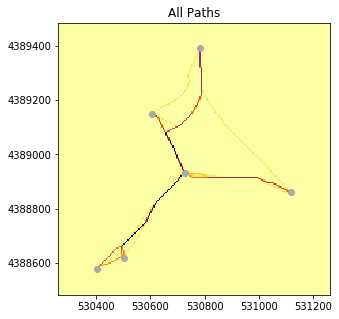

In [23]:
utils.plot_map({'ras':all_paths, 'profile':profile}, loc=df, title='All Paths', cmap= 'inferno_r')

In [24]:
df_paths

,id,origin,destination,track
0,1,"[66, 68]","[110, 93]","[[110, 109, 108, 107, 106, 105, 104, 103, 102,..."
1,2,"[66, 68]","[180, 28]","[[180, 179, 178, 177, 176, 175, 174, 173, 172,..."
2,3,"[66, 68]","[124, 171]","[[124, 124, 123, 123, 122, 122, 121, 121, 120,..."
3,4,"[66, 68]","[172, 48]","[[172, 171, 170, 169, 168, 167, 166, 165, 164,..."
4,5,"[66, 68]","[18, 104]","[[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, ..."
5,6,"[110, 93]","[180, 28]","[[180, 179, 178, 177, 176, 175, 174, 173, 172,..."
6,7,"[110, 93]","[124, 171]","[[124, 124, 123, 123, 122, 122, 121, 121, 120,..."
7,8,"[110, 93]","[172, 48]","[[172, 171, 170, 169, 168, 167, 166, 165, 164,..."
8,9,"[110, 93]","[18, 104]","[[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, ..."
9,10,"[180, 28]","[124, 171]","[[124, 124, 123, 123, 122, 122, 121, 121, 120,..."


In [25]:
df_paths = ptools.path_stats(df_paths, all_paths, df)

#### Calculate paths that maximize function

In [26]:
df_max_paths = df_paths.loc[df_paths.groupby(['path_ids'])['sum'].idxmax()]
df_max_paths

,id,path_ids,origin,destination,track,sum
17,18,"(0, 1)","[18, 104]","[124, 171]","[[124, 123, 122, 121, 120, 119, 118, 117, 116,...",365.0
15,16,"(0, 2)","[18, 104]","[180, 28]","[[180, 179, 178, 177, 176, 175, 174, 173, 172,...",1740.0
16,17,"(0, 3)","[18, 104]","[172, 48]","[[172, 171, 170, 169, 168, 167, 166, 165, 164,...",1650.0
19,20,"(0, 4)","[18, 104]","[110, 93]","[[110, 109, 108, 107, 106, 105, 104, 103, 102,...",917.0
18,19,"(0, 5)","[18, 104]","[66, 68]","[[66, 66, 67, 67, 68, 68, 69, 69, 70, 70, 71, ...",538.0
13,14,"(1, 0)","[124, 171]","[18, 104]","[[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, ...",1429.0
12,13,"(1, 3)","[124, 171]","[172, 48]","[[172, 171, 170, 169, 168, 167, 166, 165, 164,...",1321.0
28,29,"(1, 4)","[124, 171]","[110, 93]","[[110, 110, 110, 110, 110, 110, 110, 110, 110,...",526.0
27,28,"(1, 5)","[124, 171]","[66, 68]","[[66, 66, 67, 67, 68, 69, 70, 71, 72, 73, 74, ...",1007.0
11,12,"(2, 0)","[180, 28]","[18, 104]","[[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, ...",1753.0


##### Plot results

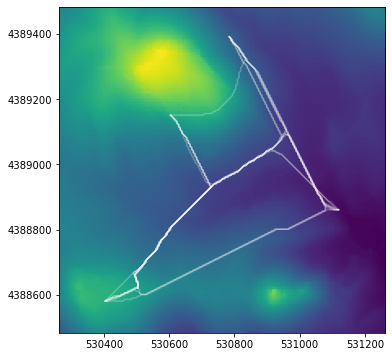

In [25]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# calculate extension
bounds = profile['bounds']
extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

# plot image
cmap = mpl.cm.get_cmap('viridis')
fig, ax = plt.subplots(ncols= 1, figsize= (6,6))
im = ax.imshow(dem, extent= extent, origin= 'upper', cmap= cmap)

for i, path in df_max_paths.iterrows():

    X = [pt[0] for pt in utils.rc2pt(path['track'], profile)]
    Y = [pt[1] for pt in utils.rc2pt(path['track'], profile)]
    ax.plot (X, Y, 'w-', alpha= 0.25)
